Epoch[1/25], G Loss: 0.1600, D Loss: 0.1897, K: 0.0010, Convergence Measure: 0.1470


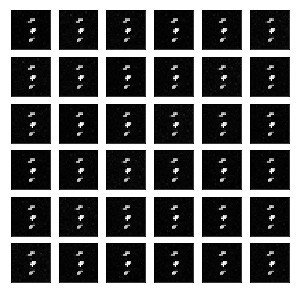

Epoch[2/25], G Loss: 0.0191, D Loss: 0.1299, K: 0.0239, Convergence Measure: 0.1929


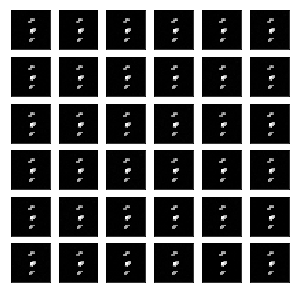

Epoch[3/25], G Loss: 0.0073, D Loss: 0.1282, K: 0.0524, Convergence Measure: 0.1750


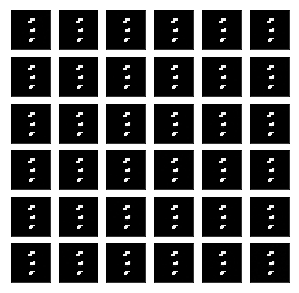

Epoch[4/25], G Loss: 0.0031, D Loss: 0.1257, K: 0.0823, Convergence Measure: 0.1814


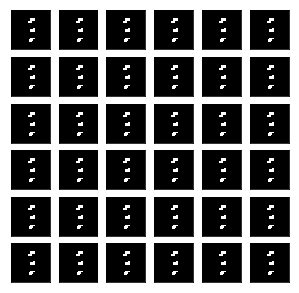

Epoch[5/25], G Loss: 0.0037, D Loss: 0.1251, K: 0.1118, Convergence Measure: 0.1850


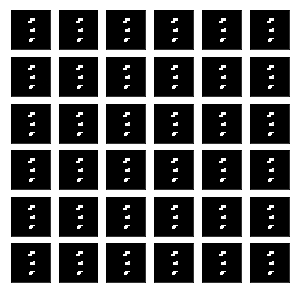

Epoch[6/25], G Loss: 0.0031, D Loss: 0.1248, K: 0.1415, Convergence Measure: 0.1739


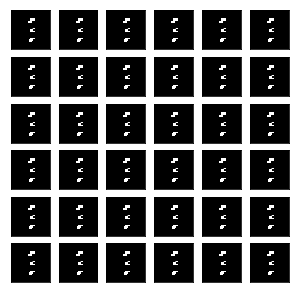

Epoch[7/25], G Loss: 0.0018, D Loss: 0.1247, K: 0.1719, Convergence Measure: 0.1984


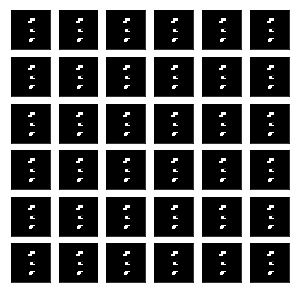

KeyboardInterrupt: 

In [17]:
""" (BEGAN)
Boundary Equilibrium GAN

https://arxiv.org/pdf/1703.10717.pdf

Matching the distributions of the reconstruction losses is a solid approximation
to matching the generated and real data distributions. While this is the idea of BEGAN, 
it is crucial to note that the reconstruction losses are NOT what we are trying to minimize. 
Instead, we derive the real loss from the Wasserstein distance between these reconstruction 
losses. 

BEGAN uses an autoencoder as a discriminator and optimizes a lower bound of the Wasserstein 
distance between auto-encoder loss distributions on realand fake data (as opposed to the 
sample distributions of the generator and real data). 

During training:

    1) D (here, an autoencoder) reconstructs real images and is optimized to minimize 
    this reconstruction loss.
    2) As a byproduct of D's optimization, the reconstruction loss of generated images 
    is increased. We optimize G to minimize the reconstruction loss of the generated images. 

This setup trains D and G simultaneously while preserving the adversarial setup.

The authors introduce an additional hyperparameter γ ∈ [0,1] to maintain the equilibrium 
between the D and G. Equilibrium between D and G occurs when E[loss(D(x))] == E[loss(D(G(z)))]. 
This γ is useful because an equilibrium is necessary for successful training of the BEGAN, and 
"the discriminator has two competing goals: auto-encode real images and discriminate real 
from generated images. The γ term lets us balance these. Lower values of γ lead to lower image 
diversity because the discriminator focuses more heavily on auto-encoding real images."
We define γ = E[loss(D(G(z)))] / E[loss(D(x))]. Then E[loss(D(G(z)))] == γE[loss(D(x))]. 
To keep this balance, the authors introduce a variable kt ∈ [0,1] to control how much emphasis to 
put on  loss(D(G(z))) during gradient descent. 

RECOMMENDED: Use a stronger GAN architecture, given that purely feedforward autoencoders are not 
great for images.
"""

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau

import os
import matplotlib.pyplot as plt
import numpy as np

from itertools import product
from tqdm import tqdm_notebook
from load_data import get_data

def to_cuda(x):
    """ Cuda-erize a tensor """
    if torch.cuda.is_available():
        x = x.cuda()
    return x

# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binarized MNIST data, separate into data loaders
# train_iter, val_iter, test_iter = get_data()


class Generator(nn.Module):
    """ Generator. Input is noise, output is a generated image. 
    """
    def __init__(self, image_size, hidden_dim, z_dim):
        super().__init__()
        
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.generate = nn.Linear(hidden_dim, image_size)
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        generation = F.sigmoid(self.generate(activated))
        return generation


class Discriminator(nn.Module):
    """ Autoencoder. Input is an image (real, generated), output is the reconstructed image. 
    """
    def __init__(self, image_size, hidden_dim):
        super().__init__()
        
        self.encoder = nn.Linear(image_size, hidden_dim)
        self.h1 = nn.Linear(hidden_dim, int(hidden_dim/2))
        self.h2 = nn.Linear(int(hidden_dim/2), int(hidden_dim/4))
        self.h3 = nn.Linear(int(hidden_dim/4), int(hidden_dim/2))
        self.decoder = nn.Linear(int(hidden_dim/2), image_size)     
        
    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        h1 = F.relu(self.h1(encoded))
        h2 = F.relu(self.h2(h1))
        h3 = F.relu(self.h3(h2))
        reconstructed = F.sigmoid(self.decoder(h3))
        return reconstructed


class BEGAN(nn.Module):
    """ Super class to contain both Discriminator (D) and Generator (G) 
    """
    def __init__(self, image_size, hidden_dim, z_dim):
        super().__init__()
        
        self.G = Generator(image_size, hidden_dim, z_dim)
        self.D = Discriminator(image_size, hidden_dim)
        
        self.z_dim = z_dim


class BEGANTrainer:
    def __init__(self, model, train_iter, val_iter, test_iter, viz=False):
        """ Object to hold data iterators, train a GAN variant """
        self.model = to_cuda(model)
        self.name = model.__class__.__name__
        
        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter
        
        self.Glosses = []
        self.Dlosses = []
        
        self.viz = viz
        
    def train(self, num_epochs, G_lr=1e-4, D_lr=1e-4, D_steps=1, GAMMA=0.50, LAMBDA=1e-3, K=0.00):
        """ Train a Bounded Equilibrium GAN
            Logs progress using G loss, D loss, visualizations of Generator output.

        Inputs:
            num_epochs: int, number of epochs to train for
            G_lr: float, learning rate for generator's Adam optimizer (default 1e-4)
            D_lr: float, learning rate for discriminator's Adam optimizer (default 1e-4)
            D_steps: int, training step ratio for how often to train D compared to G (default 1)
            GAMMA: float, hyperparameter to balance equilibrium between G and D learning objectives (default 0.50)
            LAMBDA: float, weight D loss for updating K (default 1e-3)
            K: float, initialization for how much to emphasize loss(D(G(z))) in total D loss (default 0.00)
        """
        
        # Adam optimizers
        G_optimizer = torch.optim.Adam(params=[p for p in self.model.G.parameters() if p.requires_grad], lr=G_lr)
        D_optimizer = torch.optim.Adam(params=[p for p in self.model.D.parameters() if p.requires_grad], lr=D_lr)
 
        # Reduce learning rate by factor of 2 if convergence_metric stops decreasing by a threshold for last five epochs
        G_scheduler = ReduceLROnPlateau(G_optimizer, factor=0.50, threshold=0.01, patience=5*len(train_iter))
        D_scheduler = ReduceLROnPlateau(D_optimizer, factor=0.50, threshold=0.01, patience=5*len(train_iter))
        
        # Approximate steps/epoch given D_steps per epoch --> roughly train in the same way as if D_step (1) == G_step (1)
        epoch_steps = int(np.ceil(len(train_iter) / (D_steps))) 

        # Begin training
        for epoch in tqdm_notebook(range(1, num_epochs + 1)):
            self.model.train()
            G_losses, D_losses = [], []
            
            for _ in range(epoch_steps):
                
                D_step_loss = []
                
                # TRAINING D: Train D for D_steps 
                for _ in range(D_steps):
                    
                    # Retrieve batch
                    images = self.process_batch(self.train_iter)

                    # Zero out gradients for D
                    D_optimizer.zero_grad()

                    # Train the discriminator using BEGAN loss
                    D_loss, DX_loss, DG_loss = self.train_D(images, K)
        
                    # Update parameters
                    D_loss.backward()
                    D_optimizer.step()
                    
                    # Save relevant output for progress logging
                    D_step_loss.append(D_loss.item())
                    
                # We report D_loss in this way so that G_loss and D_loss have the same number of entries
                D_losses.append(np.mean(D_step_loss))
                
                # TRAINING G: Zero out gradients for G. 
                G_optimizer.zero_grad()

                # Train the generator using BEGAN loss
                G_loss = self.train_G(images)
              
                # Update parameters
                G_loss.backward()
                G_optimizer.step()

                # Save relevant output for progress logging
                G_losses.append(G_loss.item())
                
                # PROPORTIONAL CONTROL THEORY: Dynamically update K, log convergence measure 
                convergence_measure = (DX_loss + torch.abs(GAMMA * DX_loss - DG_loss)).item()
                K_update = (K + LAMBDA * (GAMMA * DX_loss - DG_loss)).item()
                K = min(max(0, K_update), 1)
                
                # Learning rate scheduler
                D_scheduler.step(convergence_measure)
                G_scheduler.step(convergence_measure)
                
            self.Glosses.extend(G_losses)
            self.Dlosses.extend(D_losses)
            
            # Progress logging
            print ("Epoch[%d/%d], G Loss: %.4f, D Loss: %.4f, K: %.4f, Convergence Measure: %.4f"
                   %(epoch, num_epochs, np.mean(G_losses), np.mean(D_losses), K, convergence_measure))
            self.num_epochs = epoch
            
            # Visualize generator progress
            self.generate_images(epoch)
            
            if self.viz:
                plt.show()
                
    def train_D(self, images, K):
        """ Run 1 step of training for discriminator

        Input:
            images: batch of images (reshaped to [batch_size, 784])
            K: how much to emphasize loss(D(G(z))) in total D loss
        Output:
            D_loss: BEGAN loss for discriminator, E[||x - AE(x)||1] - K*E[G(z) - AE(G(z))]
        """      
        
        # Reconstruct the images using D (autoencoder), get reconstruction loss
        DX_reconst = self.model.D(images)
        DX_loss = torch.mean(torch.abs(DX_reconst - images)) # ||DX_loss||1 == DX_loss
        
        # Sample outputs from the generator
        noise = self.compute_noise(images.shape[0], self.model.z_dim)
        G_output = self.model.G(noise)
        
        # Reconstruct the generation using D (autoencoder)
        DG_reconst = self.model.D(G_output)
        DG_loss = torch.mean(torch.abs(DG_reconst - G_output)) # ||DG_loss||1 == DG_loss
        
        # Put it all together
        D_loss = DX_loss - (K * DG_loss)
        
        return D_loss, DX_loss, DG_loss
    
    def train_G(self, images):
        """ Run 1 step of training for generator
        
        Input:
            images: batch of images reshaped to [batch_size, -1]    
        Output:
            G_loss: BEGAN loss for G, E[||G(z) - AE(G(Z))||1]
        """   
        
        # Get noise, classify it using G, then reconstruct the output of G using D (autoencoder).
        noise = self.compute_noise(images.shape[0], self.model.z_dim) # z
        G_output = self.model.G(noise) # G(z)
        DG_reconst = self.model.D(G_output) # D(G(z))
        
        # Reconstruct the generation using D
        G_loss = torch.mean(torch.abs(DG_reconst - G_output)) # ||G_loss||1 == G_loss
        
        return G_loss
    
    def compute_noise(self, batch_size, z_dim):
        """ Compute random noise for the generator to learn to make images from """
        return to_cuda(torch.randn(batch_size, z_dim))
    
    def process_batch(self, iterator):
        """ Generate a process batch to be input into the discriminator D """
        images, _ = next(iter(iterator))
        images = to_cuda(images.view(images.shape[0], -1))
        return images
    
    def generate_images(self, epoch, num_outputs=36, save=True):
        """ Visualize progress of generator learning """
        # Turn off any regularization
        self.model.eval()
        
        # Sample noise vector
        noise = self.compute_noise(num_outputs, self.model.z_dim)
        
        # Transform noise to image
        images = self.model.G(noise)
        
        # Reshape to proper image size
        images = images.view(images.shape[0], 28, 28)
        
        # Plot
        plt.close()
        size_figure_grid = int(num_outputs**0.5)
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in product(range(size_figure_grid), range(size_figure_grid)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].cla()
            ax[i,j].imshow(images[i+j].data.numpy(), cmap='gray') 
        
        # Save images if desired
        if save:
            outname = '../viz/' + self.name + '/'
            if not os.path.exists(outname):
                os.makedirs(outname)
            torchvision.utils.save_image(images.unsqueeze(1).data, 
                                         outname + 'reconst_%d.png'
                                         %(epoch), nrow = 5)
    
    def viz_loss(self):
        """ Visualize loss for the generator, discriminator """
        # Set style, figure size
        plt.style.use('ggplot')
        plt.rcParams["figure.figsize"] = (8,6)

        # Plot Discriminator loss in red, Generator loss in green
        plt.plot(np.linspace(1, self.num_epochs, len(self.Dlosses)), self.Dlosses, 'r')
        plt.plot(np.linspace(1, self.num_epochs, len(self.Dlosses)), self.Glosses, 'g')
        
        # Add legend, title
        plt.legend(['Discriminator', 'Generator'])
        plt.title(self.name)
        plt.show()

    def save_model(self, savepath):
        """ Save model state dictionary """
        torch.save(self.model.state_dict(), savepath)
    
    def load_model(self, loadpath):
        """ Load state dictionary into model """
        state = torch.load(loadpath)
        self.model.load_state_dict(state)
        
        
model = BEGAN(image_size=784, 
               hidden_dim=256, 
               z_dim=128)

trainer = BEGANTrainer(model=model, 
                        train_iter=train_iter, 
                        val_iter=val_iter, 
                        test_iter=test_iter,
                        viz=True)

trainer.train(num_epochs=25,
              G_lr=1e-4,
              D_lr=1e-4,
              D_steps=1)